In [ ]:
!nvidia-smi --query-gpu=name --format=csv,noheader | head -n 1

In [1]:
import io
import time
import torch
import numpy as np
import PIL
from torchvision.transforms import ToPILImage, PILToTensor
from datasets import load_dataset, Image
from walloc import walloc
from compressai.zoo import cheng2020_anchor
from piq import LPIPS, DISTS, psnr, multi_scale_ssim

class Config: pass

In [2]:
codec = cheng2020_anchor(quality=6, metric='mse', pretrained=True)
codec.eval();

Downloading: "https://compressai.s3.amazonaws.com/models/v1/cheng2020-anchor-6-4c052b1a.pth.tar" to /home/dgj335/.cache/torch/hub/checkpoints/cheng2020-anchor-6-4c052b1a.pth.tar
100%|██████████████████████████████████████████████████████████████| 109M/109M [00:06<00:00, 16.8MB/s]


In [3]:
lpips_loss = LPIPS().to("cuda")
dists_loss = DISTS().to("cuda")

/home/dgj335/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dgj335/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
LSDIR = load_dataset("danjacobellis/LSDIR_val", split='validation')

Generating validation split:   0%|          | 0/250 [00:00<?, ? examples/s]

In [5]:
def DGML_compress(sample):
    with torch.no_grad():
        img = sample['image']
        x = PILToTensor()(img).to(torch.float)
        x = (x/255).unsqueeze(0).to(device)
        H, W = x.size(2), x.size(3)
        x_padded = walloc.pad(x,p=64)
    
        t0 = time.time()
        Y = codec.compress(x_padded)
        encode_time = time.time() - t0
    
        t0 = time.time()
        x_hat = codec.decompress(Y['strings'],Y['shape'])['x_hat']
        x_hat = x_hat.clamp(0,1)
        decode_time = time.time() - t0
        
        x_hat = walloc.crop(x_hat, (H,W))
        rec = ToPILImage()(x_hat[0])
        buff2 = io.BytesIO()
        rec.save(buff2, format='png', lossless=True)
        rec_png_bytes = buff2.getbuffer()
    
        bpp = 8*sum([sum(len(ss) for ss in s) for s in Y['strings']]) / (H*W)
        PSNR = psnr(x,x_hat)
        MSSIM = multi_scale_ssim(x,x_hat)
        LPIPS_dB = -10*np.log10(lpips_loss(x.to("cuda"), x_hat.to("cuda")).item())
        DISTS_dB = -10*np.log10(dists_loss(x.to("cuda"), x_hat.to("cuda")).item())        
        
        return {
            'recovered': rec_png_bytes,
            'encode_time': encode_time,
            'decode_time': decode_time,
            'bpp': bpp,
            'PSNR': PSNR,
            'MSSIM': MSSIM,
            'LPIPS_dB': LPIPS_dB,
            'DISTS_dB': DISTS_dB,
        }

In [6]:
device = "cuda"
codec = codec.to(device)
gpu = LSDIR.map(DGML_compress)
gpu = gpu.cast_column('recovered',Image())

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

/tmp/ipykernel_25084/2003570415.py:10: UserWarning: Inference on GPU is not recommended for the autoregressive models (the entropy coder is run sequentially on CPU).
  Y = codec.compress(x_padded)
/tmp/ipykernel_25084/2003570415.py:14: UserWarning: Inference on GPU is not recommended for the autoregressive models (the entropy coder is run sequentially on CPU).
  x_hat = codec.decompress(Y['strings'],Y['shape'])['x_hat']


In [7]:
metrics = [
     'encode_time',
     'decode_time',
     'bpp',
     'PSNR',
     'MSSIM',
     'LPIPS_dB',
     'DISTS_dB', 
]

In [9]:
for metric in metrics:
    μ = np.mean(gpu[metric])
    print(f"{metric}: {μ}")

encode_time: 4.069972817420959
decode_time: 7.961132734298706
bpp: 1.1033028017884747
PSNR: 33.77528411102295
MSSIM: 0.990258691072464
LPIPS_dB: 8.82483653284605
DISTS_dB: 16.95600639611768


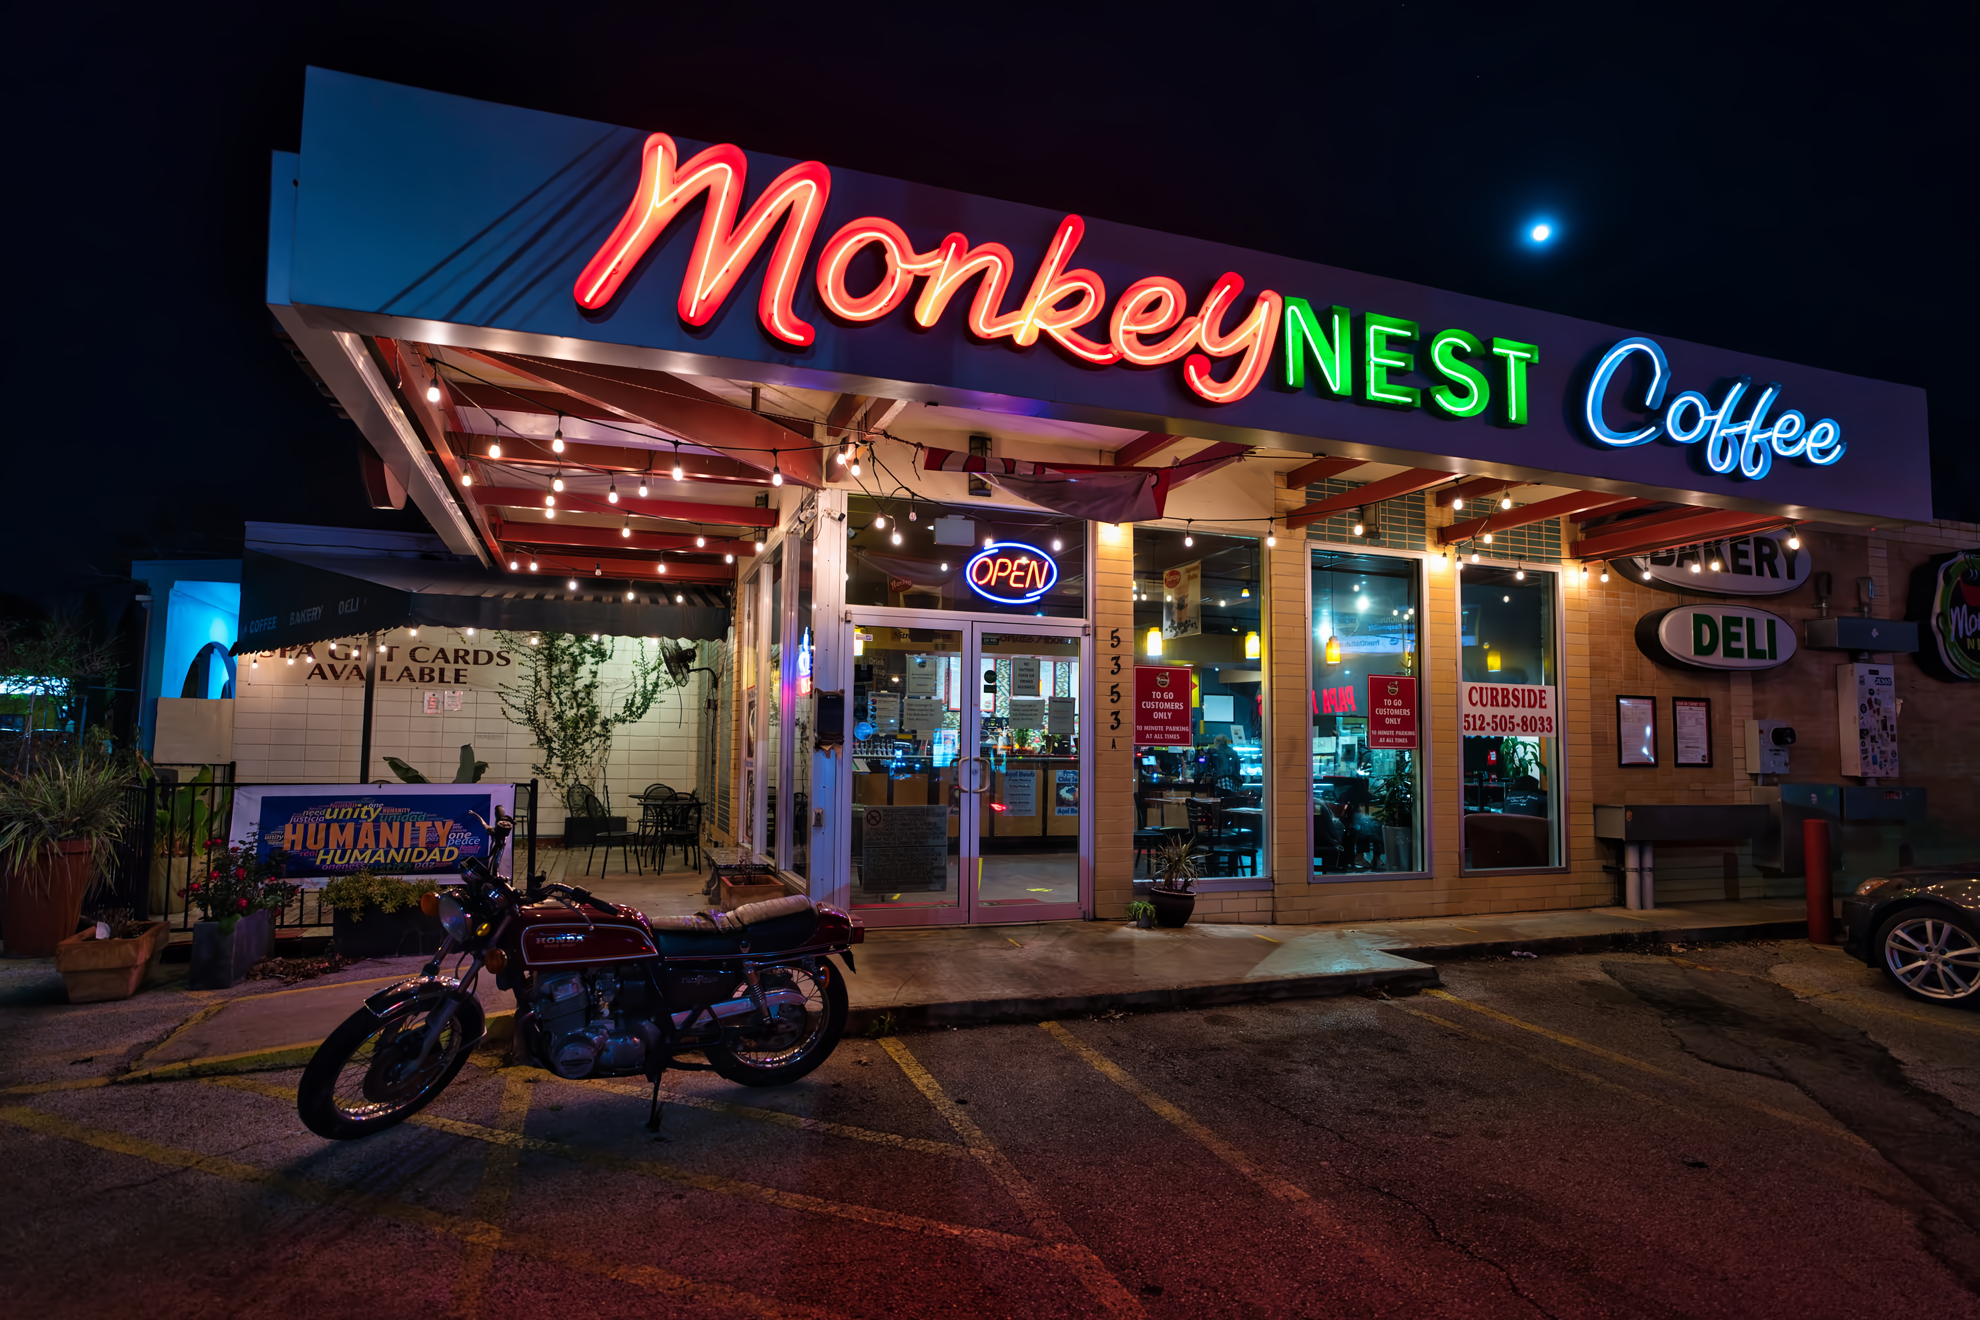

In [11]:
gpu[28]['recovered']